# Strategy creation workflow

In [127]:
import time
import math
import datetime
from IPython.display import display, clear_output
import connect as ibc
import asyncio
import pandas as pd
from ib_insync import *

import ffn

import numpy as np
util.startLoop()  # uncomment this line when in a notebook

## Establish connection to IB

In [34]:
ib = IB()
ib.connect('127.0.0.1', 7497, clientId=1)

<IB connected to 127.0.0.1:7497 clientId=1>

## Download the last ticks and create a dataframe

In [35]:
contract = Forex('EURUSD')
ib.qualifyContracts(contract)

[Forex('EURUSD', conId=12087792, exchange='IDEALPRO', localSymbol='EUR.USD', tradingClass='EUR.USD')]

In [36]:
detail = ib.reqContractDetails(contract)
print('Minimum Tick increment possible =',detail[0].minTick)

Minimum Tick increment possible = 5e-05


In [288]:
def get_historical_data():
    data = []

    start = datetime.datetime.now() - datetime.timedelta(hours=1)
    end = ''
    ticks = ib.reqHistoricalTicks(contract, start, end, 1000, 'BID_ASK', useRth=False)
    data.extend(ticks)
    actual_end = datetime.datetime.now(tz=datetime.timezone.utc)
    while data[-1].time <= actual_end:
        start = data[-1].time
        ticks = ib.reqHistoricalTicks(contract, start, end, 1000, 'BID_ASK', useRth=False)
        data.extend(ticks)
        print(data[-1].time)
    print('Download finished')
    df = []
    for tick in data:
        df.append([tick.time, tick.sizeBid, tick.priceBid, tick.priceAsk, tick.sizeAsk])
    df = pd.DataFrame(df)
    df.columns = ['time', 'bidSize', 'bid', 'ask', 'askSize']
    return df

In [289]:
df = get_historical_data()

2021-06-07 09:43:51+00:00
2021-06-07 09:46:05+00:00
2021-06-07 09:49:18+00:00
2021-06-07 09:53:39+00:00
2021-06-07 09:55:09+00:00
2021-06-07 09:56:43+00:00
2021-06-07 09:58:31+00:00
2021-06-07 09:59:57+00:00
2021-06-07 10:00:46+00:00
2021-06-07 10:02:38+00:00
2021-06-07 10:05:57+00:00
2021-06-07 10:07:30+00:00
2021-06-07 10:10:54+00:00
2021-06-07 10:13:17+00:00
2021-06-07 10:14:50+00:00
2021-06-07 10:17:37+00:00
2021-06-07 10:18:56+00:00
2021-06-07 10:20:30+00:00
2021-06-07 10:22:56+00:00
2021-06-07 10:26:15+00:00
2021-06-07 10:27:18+00:00
2021-06-07 10:28:14+00:00
2021-06-07 10:29:43+00:00
2021-06-07 10:30:30+00:00
2021-06-07 10:31:18+00:00
2021-06-07 10:33:39+00:00
2021-06-07 10:35:07+00:00
2021-06-07 10:36:24+00:00
2021-06-07 10:38:30+00:00
2021-06-07 10:40:43+00:00


In [290]:
def round_down(x: float, a: float) -> float:
    """
    Rounding function to create limit prices that are in line
    with the minimum tick size of IB as seen in the tests.ipynb.

    :param x: (float) current limit price
    :param a: (float) base where we want to round to 

    :return: (float) rounded limit price
    """
    return round(round(x / a) * a, -int(math.floor(math.log10(a))))

def round_up(x: float, a: float) -> float:
    """
    complement of round_down function that uses the original and 
    adds back the base.
    
    :param x: (float) current limit price
    :param a: (float) base where we want to round to 

    :return: (float) rounded limit price
    """
    return (round_down(x, a)+a)

<AxesSubplot:xlabel='time'>

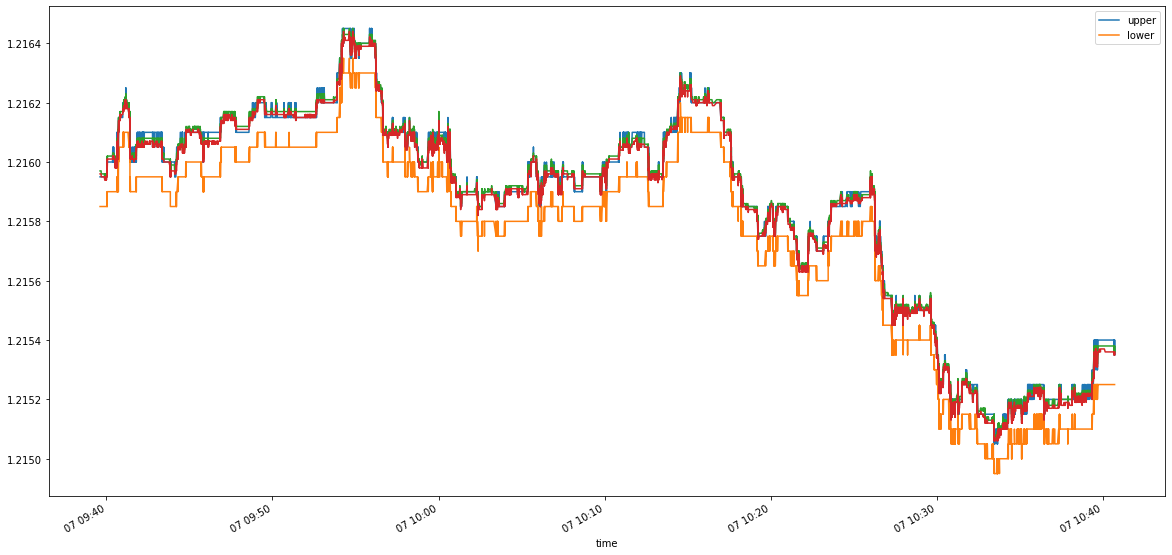

In [316]:
min_tick = detail[0].minTick
df['mid'] = (df.ask + df.bid) / 2
df['upper'] = round_up(df.ask, min_tick)-min_tick
df['lower'] = round_down(df.bid, min_tick)-2*min_tick
plt_df = df.copy()
plt_df = plt_df.set_index('time')

plt_df.upper.plot(figsize=(20,10), legend=True)
plt_df.lower.plot(legend=True)
plt_df.ask.plot()
plt_df.bid.plot()

## Create a Strategy and Backtest it 

In [321]:
def backtest(temp):
    """
    Long-only backtesting function. The values and decisions need to be changed 
    while designing your own strategy (such as thres, row['YOUR INDICATOR'], etc.).

    :param temp: pd.dataframe containing the columns mentioned.
    """
    
    long = False
    
    trades = 0
    profit = 0.0001

    up_thres = 20
    low_thres = 0

    amount = 1    
    long_price = None
    ret = []
    
    for index, row in temp.iterrows():
        
        if index%100 == 0:
            #up_thres = row['upper']
            low_thres = row['lower']

        if low_thres >= row['ask'] and not long:
            
            print('{} Long {} {} '.format(index, row['ask'], row['upper']))
            trades += 1
            long = True
            long_price = row['ask']
            up_thres = low_thres+profit
            print(up_thres)     
            ret.append(0)            
            
        elif long and up_thres <= row['bid']:

            print('{} Close Long {} {}'.format(index, row['bid'], row['lower']))
            long = False
            long_ret = ((100 / long_price * row['bid']) - 100) / 100 * amount
            ret.append(long_ret)    
            lvl = 0            
            
        elif long:

            long_ret = ((100 / long_price * row['ask']) - 100) / 100 * amount
            long_price = row['ask']
            ret.append(long_ret)
            
        else:
            ret.append(0)

    temp['returns'] = ret
    temp['cum_returns'] = (1+temp.returns).cumprod()
    
    print(trades, 'trades were made')
    print('backtest finished')
    return temp

In [322]:
ret = backtest(df)
ret = ret.set_index('time')

7096 Long 1.2161 1.2161 
1.2162
15855 Close Long 1.2162 1.2161
21473 Long 1.2158 1.2158 
1.2159
2 trades were made
backtest finished


<AxesSubplot:label='1d1481eb-2279-4ae9-93c6-edc63936ac0d'>

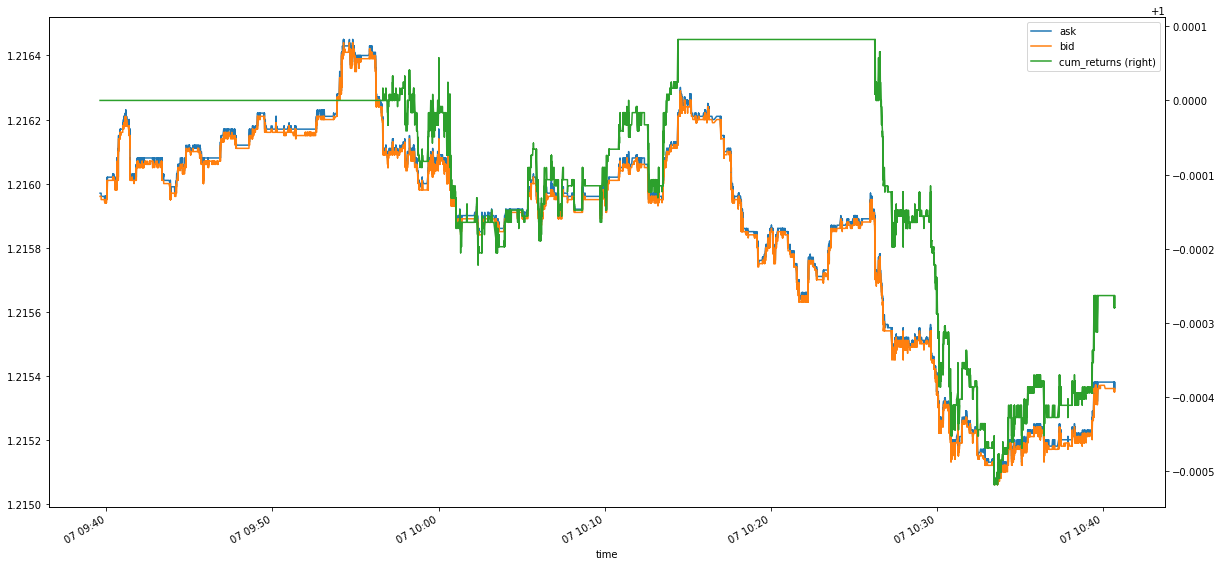

In [323]:
plt_df.ask.plot(figsize=(20,10), legend=True)
plt_df.bid.plot(legend=True)
ret.cum_returns.plot(secondary_y = True, legend=True)

In [282]:
(ret.cum_returns[-1]-1)*100

-0.0008210147084297681

In [132]:
df['ratio'] = (df.bidSize / (df.askSize+df.bidSize))
df['spread'] = df.ask - df.bid
df['bid_lagged'] = df.bid.shift(50)
df['ratio_ma'] = df.ratio.rolling(100).mean()

<AxesSubplot:label='d99574a7-4d93-47e7-80ac-43bf69c36fc9'>

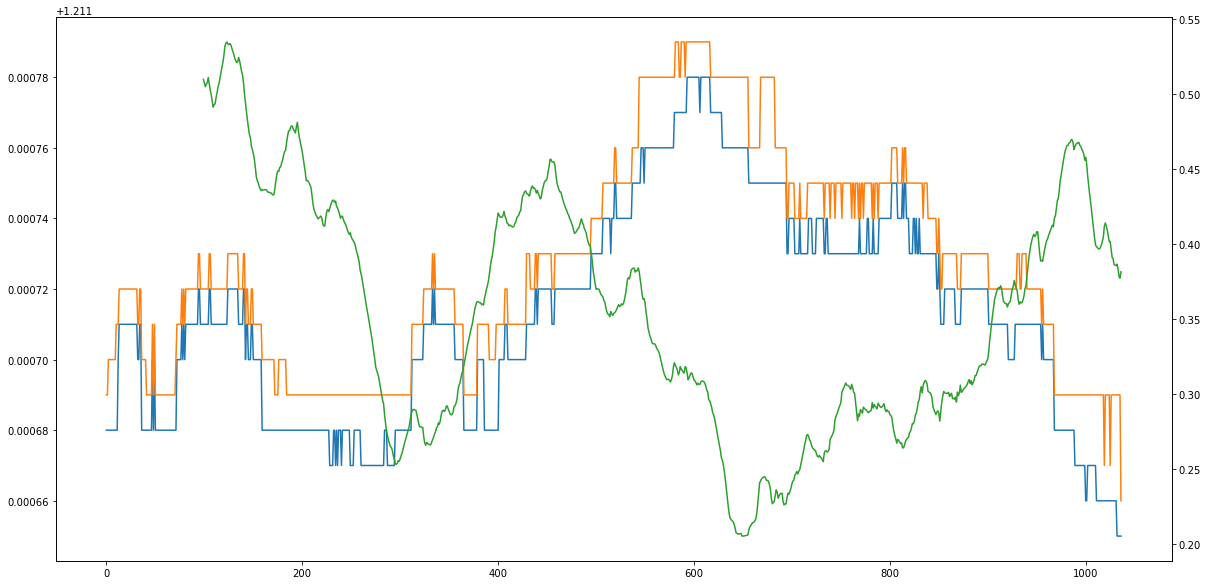

In [131]:
df.bid.plot(figsize=(20,10))
df.ask.plot()
#df.bid.shift(50).plot()
df.ratio_ma.plot(secondary_y=True)

## Disconnect from IB

In [23]:
ib.disconnect()